In [7]:
import numpy as np
import scipy.io.wavfile as wavfile
import urllib.request
import tarfile
import os
from scipy.fft import fft
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Bidirectional, Concatenate, Reshape, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from joblib import Parallel, delayed
import zipfile

In [64]:
# Step 1: Download and extract the dataset
def download_and_extract_dataset(url, extract_path='.'):
    file_name = url.split('/')[-1]
    urllib.request.urlretrieve(url, file_name)

    if file_name.endswith('.zip'):
        with zipfile.ZipFile(file_name, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
    elif file_name.endswith('.tar.gz'):
        with tarfile.open(file_name, "r:gz") as tar:
            tar.extractall(path=extract_path)
    else:
        raise ValueError("Unsupported file format. Please provide a .zip or .tar.gz file.")

    print(f'Dataset downloaded and extracted to {extract_path}')

# Step 2: Load dataset RIR data
def load_rir_data(base_path='./RIRS_NOISES/', downsample_factor=2):
    data = []
    labels = []
    max_length = 0

    for subdir in ['real_rirs_isotropic_noises', 'simulated_rirs']:
        subdir_path = os.path.join(base_path, subdir)
        if os.path.isdir(subdir_path):
            for file_name in os.listdir(subdir_path):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(subdir_path, file_name)
                    rate, signal = wavfile.read(file_path)
                    signal = signal[::downsample_factor]  # downsample the signal for speed

                    # Handle stereo signals
                    if signal.ndim > 1:
                        signal = np.mean(signal, axis=1)
                    max_length = max(max_length, len(signal))
                    data.append(signal)
                    # Extract the labels from the filenames or
                    if subdir == 'real_rirs_isotropic_noises':
                        label = file_name.split('_')[0]  # Extract noise types from the filename
                    else:
                        label = subdir_path.split('/')[-1]  # Extract room size from subdirectory name

                    labels.append(label)
    data = pad_sequences(data, maxlen=max_length, padding='post')
    return np.array(data), np.array(labels)

# Step 3: Extract Fourier transforms as features
def extract_fourier_features(X):
    def fft_transform(signal):
        return np.abs(fft(signal))

    n_jobs = -1  # Use all available CPU cores
    X_fourier = Parallel(n_jobs=n_jobs)(delayed(fft_transform)(signal) for signal in X)
    return np.array(X_fourier)

# Step 4: Apply PCA for dimensionality reduction
def apply_pca(X_train, X_test, n_components=100):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca

# Step 5: Data Augmentation
def augment_data(X, y):
    noise_factor = 0.05
    X_augmented = X + noise_factor * np.random.randn(*X.shape)
    y_augmented = y
    return np.concatenate([X, X_augmented]), np.concatenate([y, y_augmented])

# Step 6: Create Encoders
def create_encoders(input_shape):
    inputs = Input(shape=input_shape)

    # encode content
    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(256, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    content_encoder_output = Flatten()(x)

    # Rhythm
    y = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    y = BatchNormalization()(y)
    y = MaxPooling1D(pool_size=2)(y)
    rhythm_encoder_output = Flatten()(y)

    # Pitch
    z = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    z = BatchNormalization()(z)
    z = MaxPooling1D(pool_size=2)(z)
    z = Bidirectional(LSTM(32))(z)
    pitch_encoder_output = Flatten()(z)

    return Model(inputs, [content_encoder_output, rhythm_encoder_output, pitch_encoder_output])

# Step 7: Create CNN Decoder
def create_cnn_decoder(content_shape, rhythm_shape, pitch_shape, num_classes):
    content_input = Input(shape=content_shape)
    rhythm_input = Input(shape=rhythm_shape)
    pitch_input = Input(shape=pitch_shape)

    # concatenate inputs
    merged = Concatenate()([content_input, rhythm_input, pitch_input])

    # Calculate the correct reshape dimensions using the feature dimension
    feature_dim_content = content_shape[0]
    feature_dim_rhythm = rhythm_shape[0]
    feature_dim_pitch = pitch_shape[0]

    reshape_dim1 = feature_dim_content + feature_dim_rhythm + feature_dim_pitch  # Total flattened dimension

    print(f"Feature dimension content: {feature_dim_content}, rhythm: {feature_dim_rhythm}, pitch: {feature_dim_pitch}")
    print(f"Total reshape dimension: {reshape_dim1}")

    # Reshape to (batch_size, reshaped_dim, 1) for Conv1D
    x = Reshape((reshape_dim1, 1))(merged)  # Reshape to include the channel dimension

    print(f"Shape after reshape: {x.shape}")

    #  Conv1D layers
    x = Conv1D(64, kernel_size=3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, kernel_size=3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    # Ensure correct flattening dimension
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model([content_input, rhythm_input, pitch_input], outputs)

# Step 8: SVM Kernel System
def svm_kernel_system(X_train, y_train, X_test, y_test):
    classifier = svm.SVC(kernel='rbf', gamma='scale')
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return classifier, accuracy


In [3]:
# Download dataset
url = 'http://www.openslr.org/resources/28/rirs_noises.zip'
download_and_extract_dataset(url)

Dataset downloaded and extracted to .


In [61]:
# Load dataset
X, y = load_rir_data()

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Extract Fourier features
X_fourier = extract_fourier_features(X)
X_fourier = (X_fourier - np.mean(X_fourier, axis=0)) / np.std(X_fourier, axis=0)

X_train, X_test, y_train, y_test = train_test_split(X_fourier, y_encoded, test_size=0.2, random_state=42)
X_train_pca, X_test_pca = apply_pca(X_train, X_test, n_components=100)
X_train_pca, y_train = augment_data(X_train_pca, y_train)

svm_classifier, svm_accuracy = svm_kernel_system(X_train_pca, y_train, X_test_pca, y_test)
print(f'SVM Accuracy: {svm_accuracy}')

input_shape = (X_train_pca.shape[1], 1)
X_train_pca = X_train_pca.reshape((X_train_pca.shape[0], X_train_pca.shape[1], 1))
X_test_pca = X_test_pca.reshape((X_test_pca.shape[0], X_test_pca.shape[1], 1))

print("X_train_pca shape:", X_train_pca.shape)
print("X_test_pca shape:", X_test_pca.shape)

encoders = create_encoders(input_shape)
content_train, rhythm_train, pitch_train = encoders.predict(X_train_pca)
content_test, rhythm_test, pitch_test = encoders.predict(X_test_pca)

num_classes = len(label_encoder.classes_)

# Create and train CNN decoder
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Update input shapes based on encoder outputs
cnn_decoder = create_cnn_decoder(
    content_shape=(content_train.shape[1],),
    rhythm_shape=(rhythm_train.shape[1],),
    pitch_shape=(pitch_train.shape[1],),
    num_classes=num_classes
)

# Compile the CNN decoder prior to fitting
cnn_decoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

cnn_decoder.fit(
    [content_train, rhythm_train, pitch_train],
    y_train_categorical,
    epochs=10,
    batch_size=32,
    validation_data=([content_test, rhythm_test, pitch_test], y_test_categorical),
    callbacks=[early_stopping]
)

# Evaluate CNN
cnn_loss, cnn_accuracy = cnn_decoder.evaluate([content_test, rhythm_test, pitch_test], y_test_categorical)
print(f'CNN Accuracy: {cnn_accuracy}')


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


SVM Accuracy: 0.9166666666666666
X_train_pca shape: (666, 100, 1)
X_test_pca shape: (84, 100, 1)
3/3 [==============================] - 0s 9ms/step
Feature dimension content: 6400, rhythm: 3200, pitch: 64
Total reshape dimension: 9664
Shape after reshape: (None, 9664, 1)
Epoch 1/10
21/21 [==============================] - 18s 741ms/step - loss: 32.2023 - accuracy: 0.7132 - val_loss: 6.7690 - val_accuracy: 0.7381
Epoch 2/10
21/21 [==============================] - 15s 734ms/step - loss: 7.3473 - accuracy: 0.8859 - val_loss: 11.9330 - val_accuracy: 0.6548
Epoch 3/10
21/21 [==============================] - 15s 729ms/step - loss: 1.4710 - accuracy: 0.9369 - val_loss: 1.6830 - val_accuracy: 0.7500
Epoch 4/10
21/21 [==============================] - 15s 730ms/step - loss: 1.3570 - accuracy: 0.9384 - val_loss: 2.7855 - val_accuracy: 0.7024
Epoch 5/10
21/21 [==============================] - 15s 734ms/step - loss: 1.2592 - accuracy: 0.9655 - val_loss: 4.1592 - val_accuracy: 0.6667
Epoch 6/10


In [68]:
# Step 9: Bringing everything together
def combine_predictions(cnn_model, svm_model, X_cnn, X_svm):
    # Get CNN predictions
    cnn_preds = cnn_model.predict(X_cnn)
    cnn_preds_classes = np.argmax(cnn_preds, axis=1)

    # Get SVM predictions
    # Reshape X_svm to 2D before prediction
    svm_preds_classes = svm_model.predict(X_svm.reshape(X_svm.shape[0], -1))

    # Combine predictions (e.g., by majority voting)
    combined_preds = []
    for i in range(len(cnn_preds_classes)):
        combined_pred = np.bincount([cnn_preds_classes[i], svm_preds_classes[i]]).argmax()
        combined_preds.append(combined_pred)

    return np.array(combined_preds)

# Use combined model to predict and evaluate
combined_predictions = combine_predictions(
    cnn_decoder,
    svm_classifier,
    [content_test, rhythm_test, pitch_test],
    X_test_pca
)

combined_accuracy = accuracy_score(y_test, combined_predictions)
print(f'Combined Model Accuracy: {combined_accuracy}')

3/3 [==============================] - 0s 56ms/step
Combined Model Accuracy: 0.8452380952380952


In [69]:
from sklearn.metrics import confusion_matrix, classification_report

# Step 10: System Evaluation
def evaluate_model_performance(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix:\n', cm)

    report = classification_report(y_true, y_pred, target_names=labels)
    print('Classification Report:\n', report)

evaluate_model_performance(y_test, combined_predictions, label_encoder.classes_)


Confusion Matrix:
 [[22  5  0]
 [ 0 40  0]
 [ 0  8  9]]
Classification Report:
               precision    recall  f1-score   support

     RVB2014       1.00      0.81      0.90        27
        RWCP       0.75      1.00      0.86        40
         air       1.00      0.53      0.69        17

    accuracy                           0.85        84
   macro avg       0.92      0.78      0.82        84
weighted avg       0.88      0.85      0.84        84



3/3 [==============================] - 0s 54ms/step


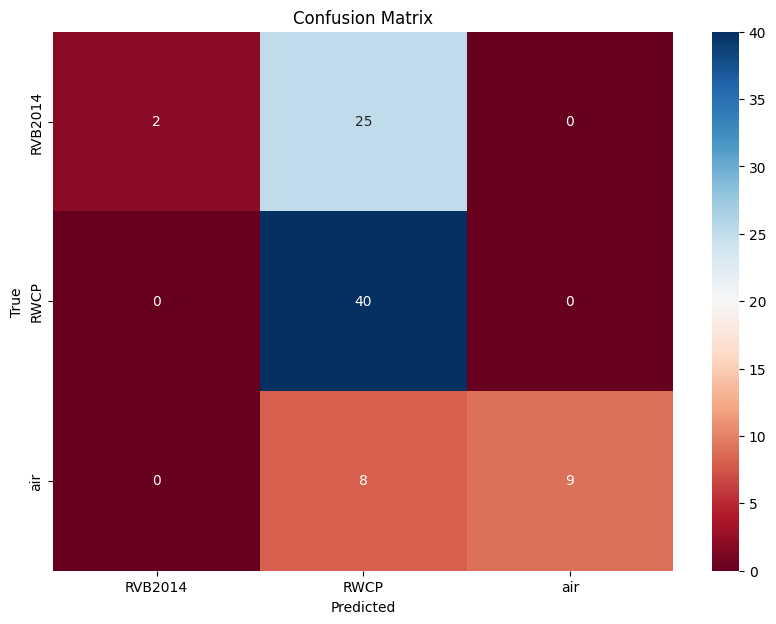

<Figure size 1000x700 with 0 Axes>

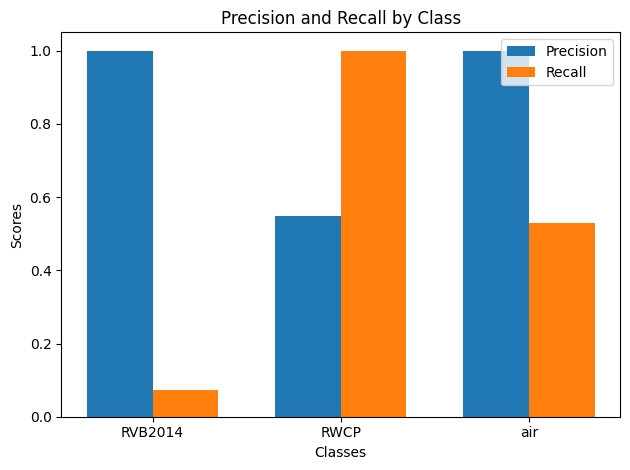

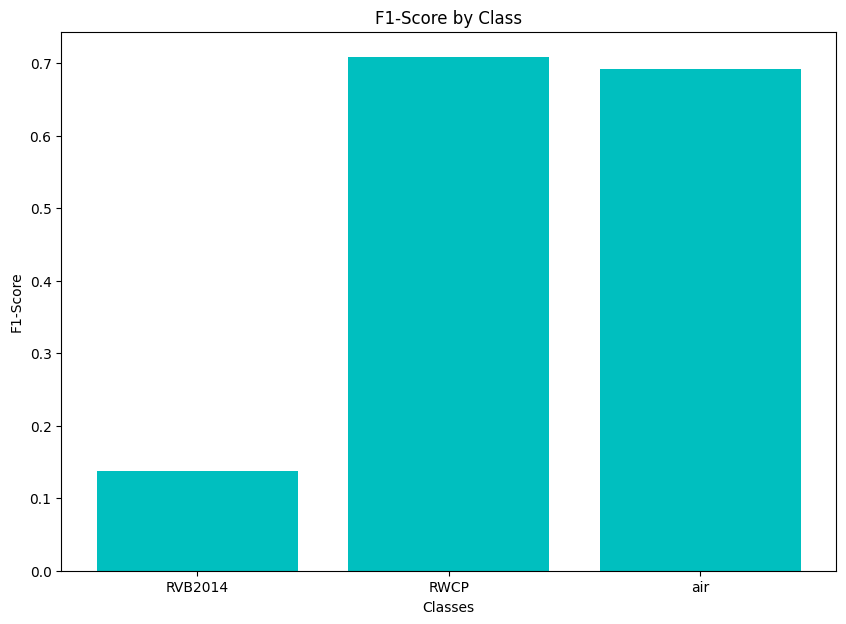

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_true = y_test
y_pred = cnn_decoder.predict([content_test, rhythm_test, pitch_test])
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
labels = label_encoder.classes_

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdBu', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred_classes, target_names=labels, output_dict=True)

precision = [report[label]['precision'] for label in labels]
recall = [report[label]['recall'] for label in labels]
f1_score = [report[label]['f1-score'] for label in labels]

# Plot Precision and Recall Bar Chart
x = np.arange(len(labels))

plt.figure(figsize=(10, 7))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, precision, width, label='Precision')
rects2 = ax.bar(x + width/2, recall, width, label='Recall')

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision and Recall by Class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

# Plot F1-Score Bar Chart
plt.figure(figsize=(10, 7))
plt.bar(labels, f1_score, color='c')
plt.xlabel('Classes')
plt.ylabel('F1-Score')
plt.title('F1-Score by Class')
plt.show()
